# GIS routing

We won't introduce any new concept/algorithm here.  

Just a new map but we will perform all the algorithms in the same notebook so you could see the difference with respect to time/efficiency and see how the **nodes are expanded** in each of the previous algorithm in real-time.

In [19]:
%%capture

##############################################################################
# IGNORE if you are running on a local machine and have all the dependencies #
##############################################################################

# installing dependencies --- to be able to run on google colab
# it would take 2-3 minutes
!apt-get install libspatialindex-c4v5;
!pip3 install Rtree;
!pip3 install osmnx;
!pip3 install tqdm;
# you HAVE to upload a number of files and folders used in the code
# problem.py - utils.py 
# upload them in the home directory --- don't go into any folder, just press upload button
#|- problem.py
#|- utils.py

# Getting the map

In [1]:
import osmnx as ox
from IPython.display import IFrame, HTML
import matplotlib.animation as animation
from matplotlib.collections import LineCollection
import matplotlib.pyplot as plt
from operator import attrgetter
from tqdm import tqdm
import numpy as np
import time
from collections import deque
import networkx as nx
from problem import *
from utils import *

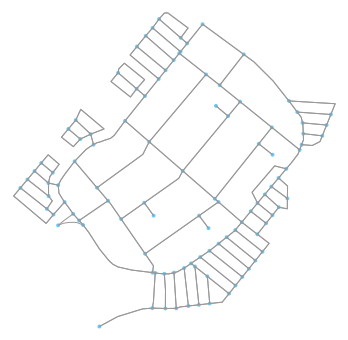

In [2]:
G = ox.graph_from_place('toronto premium outlets')
fig, ax = ox.plot_graph(G)

In [3]:
graph_map = ox.plot_graph_folium(G, edge_width=2)
filepath = './data/graph.html'
graph_map.save(filepath)
IFrame(filepath, width=600, height=500)

let's find two vertices to be our source and destination

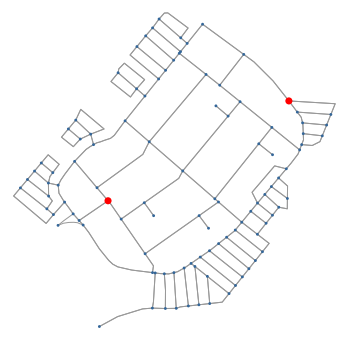

In [4]:
nc = ['r' if node == 6655397492 or node == 2493811210 else '#336699' for node in G.nodes()]
ns = [50 if node == 6655397492 or node == 2493811210 else 8 for node in G.nodes()]
fig, ax = ox.plot_graph(G, node_size=ns, node_color=nc, node_zorder=2)

So let's state our new problem, I want to get from Starbucks to the parking on the other side of the outlet. But I want to be cool and use graph search algorithms and animate them, let's get to work then.

In [5]:
%%capture
source(Node)
# first define the origin/source nodes as Node
origin = Node(graph = G, node = G[6655397492], osmid = 6655397492, distance = 0, parent = None)
destination = Node(graph = G, node = G[2493811210], osmid = 2493811210)

**note**: From this notebook and moving forward, I will be using packing/unpacking operators (`*`-`**`) in `Python` and you may find them confusing if it's your first time seeing them. So, please take your time untill you become comfortable with them.

### Breadth First Search
please note `colors` array which serves as stamp for the current state of the traversing and expansion of the nodes, would be used in animations.*

In [9]:
bar = tqdm(total=len(G))
colors = []
route = []
frontier = deque([origin])
explored = set()
found = False
while frontier and not found:
    bar.update(1); time.sleep(0.1)
    node = frontier.popleft()
    explored.add(node)
    for child in node.expand():
        if child not in explored and child not in frontier:
            if child == destination:
                route, cost = child.path()
                print(route)
                found = True
            frontier.append(child)
    frontierOsmid = [node.osmid for node in explored]
    colornow = [1 if node in frontierOsmid else 6 for node in G.nodes()]
    colors.append(colornow)

bar.close()
# print(route)

  0%|          | 0/105 [00:00<?, ?it/s]

[6655397492, 6655397503, 6655397505, 6655397506, 6655397508, 6655397494, 2493811210]


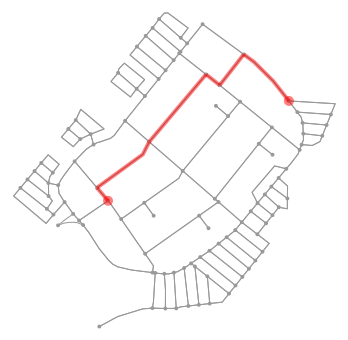

In [7]:
fig, ax = ox.plot_graph_route(G, route)

Focus on how breadth first search traverse on the graph and how it expands on all directions and waste time

In [8]:
%%capture
ani = animate_simple(G, np.array(colors))

In [9]:
HTML(ani.to_html5_video())

### Depth First Search

In [10]:
route = []
bar = tqdm(total=len(G))
colors = []
frontier = deque([origin])
explored = set()
found = False
while frontier and not found:
    bar.update(1); time.sleep(0.1)
    node = frontier.pop()
    explored.add(node)
    if node == destination:
        route, cost = node.path()
        found = True
        continue
    for child in node.expand():
        if child not in explored and child not in frontier:
            if child == destination:
                route, cost = child.path()
                found = True
                continue
            frontier.append(child)
    frontierOsmid = [node.osmid for node in explored]
    colornow = [1 if node in frontierOsmid else 6 for node in G.nodes()]
    colors.append(colornow)
bar.close()
print(route)

 67%|██████▋   | 70/105 [00:07<00:03,  9.73it/s]

[6655397492, 6655397499, 6655397498, 6655397512, 6655299771, 6655299769, 6655299767, 4689697912, 4689697914, 4689697910, 4689697908, 4689697916, 4689697918, 4689697920, 4689697922, 4689697925, 4689697926, 4689697986, 4689697985, 4689697982, 4689697987, 4689697975, 4689698190, 4689697977, 6655397509, 6655397495, 6655397502, 6655397508, 6655397494, 2493811210]


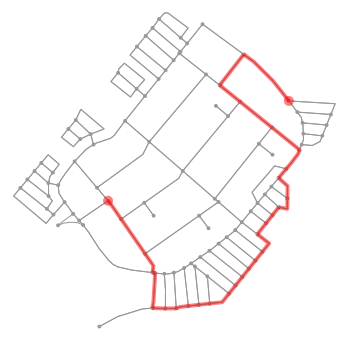

In [11]:
fig, ax = ox.plot_graph_route(G, route)

What can we learn from the below animation and `tqdm` progress bar about DFS?  

BFS my be wasting its time expanding hopeless nodes but it changes its mind quickly, DFS do the same thing but there is insistence to finish a certain road till the end and then backtrack.  

DFS is only good for its memory consumption.

In [12]:
%%capture
ani = animate_simple(G, np.array(colors))

In [13]:
HTML(ani.to_html5_video())

### A* search

In [14]:
toGoal, toDestination = Astar_distance(G, 6655397492, 2493811210)

In [15]:
frontier = PriorityQueue('min', lambda node: toGoal[node.osmid] + toDestination[node.osmid])
colors = []
route = []
bar = tqdm(total=len(G))

frontier.append(origin)
explored = set()
found = False
while frontier and not found:
    bar.update(1); time.sleep(0.1)
    node = frontier.pop()
    explored.add(node)
    if node == destination:
        route, cost = node.path()
        found = True
        continue
    for child in node.expand():
        if child not in explored and child not in frontier:
            if child == destination:
                route, cost = child.path()
                found = True
                continue
            frontier.append(child)
    frontierOsmid = [node.osmid for node in explored]
    colornow = [1 if node in frontierOsmid else 6 for node in G.nodes()]
    colors.append(colornow)
bar.close()
print(route)

 21%|██        | 22/105 [00:02<00:08,  9.74it/s]

[6655397492, 6655397499, 6655614319, 6655397501, 6655572411, 6655397502, 6655397508, 6655397494, 2493811210]


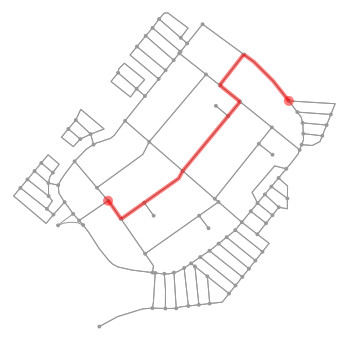

In [16]:
fig, ax = ox.plot_graph_route(G, route)

A* is the best algorithm in the traditional search methods and used in a lot of routing and navigation system, why?  
Its heuristic is very useful in directing the search and the traversing as it has _eyes_ on __both__ the origin and destination.

In [17]:
%%capture
ani = animate_simple(G, np.array(colors))

In [18]:
HTML(ani.to_html5_video())

### Dijkstra Algorithm

In [21]:
route = []
bar = tqdm(total=len(G))
colors = []
frontier = [origin]
explored = set()
found = False
while frontier and not found:
    bar.update(1); time.sleep(0.1)
    # This is the closest node to the origin .. this is pretty much Dijkstra algorithm idea
    node = min(frontier, key = attrgetter('from_origin'))
    frontier.remove(node)
    explored.add(node)
    if node == destination:
        route, cost = node.path()
        found = True
        continue
    for child in node.expand():
        if child not in explored and child not in frontier:
            if child == destination:
                route, cost = child.path()
                found = True
                continue
            frontier.append(child)
    frontierOsmid = [node.osmid for node in explored]
    colornow = [1 if node in frontierOsmid else 6 for node in G.nodes()]
    colors.append(colornow)
bar.close()
print(route)

 80%|████████  | 84/105 [00:08<00:02,  9.74it/s]

[6655397492, 6655397503, 6655397505, 6655397506, 6655397508, 6655397494, 2493811210]


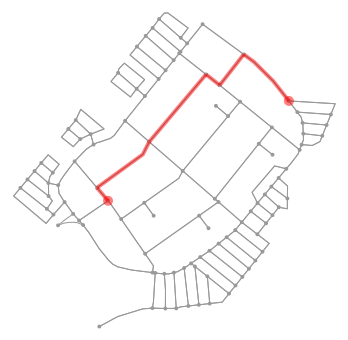

In [22]:
fig, ax = ox.plot_graph_route(G, route)

Maybe dijkstra is not the fastest or the _smartest_ algorithm, but it is the only algorithm that gives us THE shortest path on a graph.

Please note that

In [23]:
%%capture
ani = animate_simple(G, np.array(colors))

In [24]:
HTML(ani.to_html5_video())